# TP3
Por Mariano Parada <BR>
DS-33  -  2020<BR>
[Github](https://github.com/marianoparada/DataScience)


### Aclaraciones previas:
Para agilizar el proceso se tomó una muestra del 15%  (si se quisiera ver el universo, cambiar la variable [muestra] de la celda 7)

In [ ]:
# ! pip install sentiment-analysis-spanish

In [2]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
import pandas as pd
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
stemmer = PorterStemmer()
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
lemmatizer = WordNetLemmatizer()
# Guardamos las stopwords en español en una variable
stopwords = nltk.corpus.stopwords.words('spanish')
stop_words = stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mariano\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mariano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mariano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mariano\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
import pandas as pd
dev=pd.read_json(r'C:\Users\Mariano\Desktop\Acamica\TP3\NLP\dataset_es_dev.json', lines=True)
test=pd.read_json(r'C:\Users\Mariano\Desktop\Acamica\TP3\NLP\dataset_es_test.json', lines=True)
train=pd.read_json(r'C:\Users\Mariano\Desktop\Acamica\TP3\NLP\dataset_es_train.json', lines=True)

In [4]:
data = pd.concat([dev,test,train], axis=0)

In [5]:
# Veamos si coincide la estructura de los JSON

In [6]:
data.head(1)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless


### Veamos una aproximación inicial a cantidad de registros, desviación standard, valores mínimos y máximos y distribución:

In [7]:
data.describe

<bound method NDFrame.describe of          review_id          product_id          reviewer_id  stars  \
0       es_0417480  product_es_0873923  reviewer_es_0672978      1   
1       es_0180432  product_es_0713146  reviewer_es_0100858      1   
2       es_0144850  product_es_0356874  reviewer_es_0486447      1   
3       es_0339629  product_es_0939832  reviewer_es_0894703      1   
4       es_0858362  product_es_0489066  reviewer_es_0887663      1   
...            ...                 ...                  ...    ...   
199995  es_0715276  product_es_0317036  reviewer_es_0643604      5   
199996  es_0085190  product_es_0622919  reviewer_es_0466173      5   
199997  es_0484496  product_es_0358101  reviewer_es_0330744      5   
199998  es_0930141  product_es_0788855  reviewer_es_0694290      5   
199999  es_0859809  product_es_0378794  reviewer_es_0141717      5   

                                              review_body  \
0       Malisimo, muy grande demasiado aparatoso y mal...   
1  

In [8]:
#Sacamos una muestra aleatoria. En muestra se debe poner el porcentaje a considerar.
#Dada la cantidad de registros estadísticamente la muestra nos dá métricas confiables por arriba del 10% 
muestra=15
experiment_size = int(len(data.index)*muestra/100)
completerandom_idx = data.sample(int(experiment_size),random_state = 42).index
data = data.loc[completerandom_idx,:]
data.shape

(35932, 8)

### Conclusiones preliminares:
Las columnas review_id, product_id, reviewer_id : tienen concatenado texto a un valor numérico.Hay que quitarle el texto

In [9]:
data['review_id'] = data['review_id'].map(lambda x: x.lstrip('es_'))
data['product_id'] = data['product_id'].map(lambda x: x.lstrip('product_es_'))
data['reviewer_id'] = data['reviewer_id'].map(lambda x: x.lstrip('reviewer_es_'))

# Creacion de características:
1. Vamos a crear el promedio de calificacion para cada categoría de producto.<br>
2. Vamos a unir el título y la reseña en un campo "cuerpo".<br>

In [10]:
data['promprod'] = data.groupby(['product_category'])['stars'].transform('mean')
data['cuerpo'] = data[['review_title', 'review_body']].apply(' . '.join, axis=1)

In [11]:
data.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,promprod,cuerpo
184949,0551312,0105367,0461939,5,Sabor y textura idéales! Me ha encantado! Ante...,Saludable y delicioso,es,grocery,3.010753,Saludable y delicioso . Sabor y textura idéale...
151875,0332711,0776227,0439865,4,"La funda cumple su finalidad, y apaga la panta...",Cumple.,es,other,2.990113,"Cumple. . La funda cumple su finalidad, y apag..."


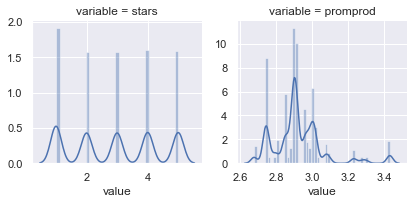

In [12]:
# Credits to Dominik Gawlik in Kaggle: https://www.kaggle.com/dgawlik/house-prices-eda
features = [f for f in data.columns if data.dtypes[f] != 'object']
melt = pd.melt(data, value_vars = features)
facetgrid = sns.FacetGrid(melt, col = "variable",  col_wrap = 2, sharex = False, sharey = False)
distribucion = facetgrid.map(sns.distplot, "value")

In [13]:
# verificamos que no hay más de un lenguage :

In [14]:
data.groupby('language').size()

language
es    35932
dtype: int64

In [15]:
#Verificamos que no haya usuarios con demasiadas calificaciones
data.groupby('reviewer_id').size().sort_values(ascending=False)

reviewer_id
0379892    4
0207911    4
0485390    4
0582207    3
0899425    3
          ..
0656818    1
0656847    1
0656870    1
0656882    1
0000014    1
Length: 34181, dtype: int64

In [16]:
#Verificamos que no haya productos con demasiadas calificaciones
data.groupby('product_id').size().sort_values(ascending=False)

product_id
0400389    4
0888698    4
0482561    4
0795520    4
0349962    4
          ..
0655079    1
0655094    1
0655098    1
0655113    1
0000014    1
Length: 33111, dtype: int64

In [17]:
# Verificamos valores faltantes

In [18]:
print("\nValores faltantes\n" )
print (data.isnull().sum())


Valores faltantes

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
promprod            0
cuerpo              0
dtype: int64


### Veamos si están balanceada nuestra variable de respuesta (stars) ...

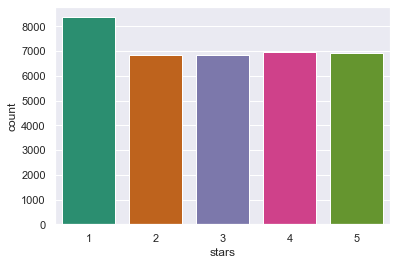

In [19]:
sns.countplot(data.stars, palette="Dark2")
plt.show()

La variable de respuesta se encuentra balanceada.

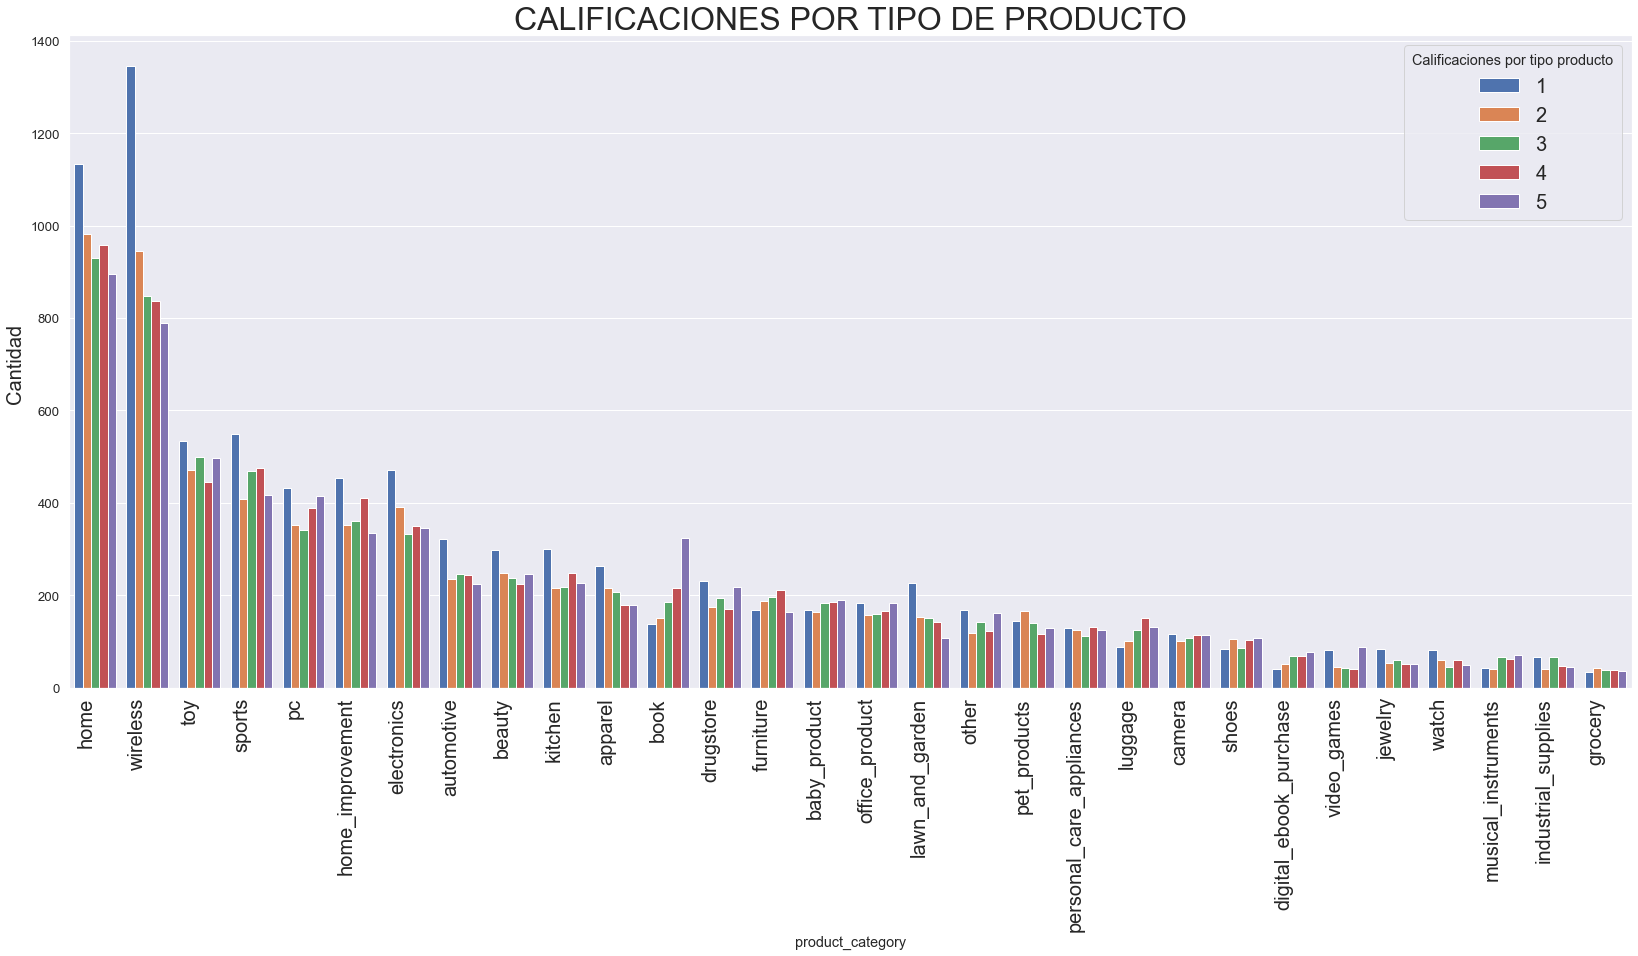

In [20]:
# vemos las calificaciones por tipo de prodcto
plt.figure(figsize=(28,12),facecolor='white',edgecolor='white')    # Cambio el tamaño para que sea legible
sns.set(context='notebook',font='sans-serif',font_scale=1.2)
ax = sns.countplot(x="product_category", hue= "stars", data=data,saturation=0.95,linewidth=1, order = data['product_category'].value_counts().index ,dodge = True)
plt.title('CALIFICACIONES POR TIPO DE PRODUCTO',fontdict = {'fontsize': 32,'fontweight' :3, 'verticalalignment': 'baseline'})
plt.ylabel('Cantidad ', fontsize=20)
plt.xticks(rotation=90 , ha='right', fontsize=20)
plt.legend(loc='upper right' ,title = 'Calificaciones por tipo producto', bbox_to_anchor=(1, 1), fontsize=20)
#plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.show()

Como se puede apreciar, las calificaciones estan bien distribuidas. No hay categorías que esten significativamente desbalanceadas (solo un poco HOME y WIRELESS).
Nota de color: Las categorías "apariencia" y "libros" estan en espejo, es decir: 12345 - 54321 , como si culturalmente fueran personalidades opuestas.

In [21]:
# Veamos si la longitud del texto incide en la calificación otorgada:
data['largo'] = data['cuerpo'].apply(len)
data.head(1)


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,promprod,cuerpo,largo
184949,0551312,0105367,0461939,5,Sabor y textura idéales! Me ha encantado! Ante...,Saludable y delicioso,es,grocery,3.010753,Saludable y delicioso . Sabor y textura idéale...,167


### Incidirá la longitud de la reseña en la calificación ? 

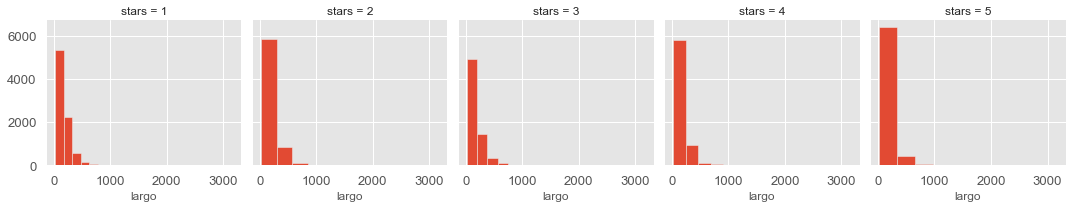

In [22]:
plt.style.use(['ggplot']) 
g = sns.FacetGrid(data,col='stars')
g.map(plt.hist,'largo')

# Algunas conclusiones...
Las bases estan balanceadas.<BR> 
No hay usuarios ni productos con cantidades exageradas de calificaciones que ameriten alguna corrección.<BR>
En general el largo de la reseña no guarda relación con la calificación.<BR>


In [23]:
# Vamos a eliminar algunas columnas:
data.drop(['review_id','product_id','reviewer_id','review_body','review_title','language','largo'], axis = 'columns', inplace=True)

In [24]:
data.head(1)

,stars,product_category,promprod,cuerpo
184949,5,grocery,3.010753,Saludable y delicioso . Sabor y textura idéale...


### Vamos a utilizar la función polarity_scores de NLTK VADER
La misma asigna un valor negativo, positivo, neutro y un consolidado para un texto para ver si logramos una correlación entre algunos de estos valores y las calificaciones otorgadas:

In [25]:
data["neg"] = data["cuerpo"].apply(lambda x:sia.polarity_scores(x)["neg"])
data["pos"] = data["cuerpo"].apply(lambda x:sia.polarity_scores(x)["pos"])
data["neu"] = data["cuerpo"].apply(lambda x:sia.polarity_scores(x)["neu"])
data["compuesto"] = data["cuerpo"].apply(lambda x:sia.polarity_scores(x)["compound"])

In [26]:
data.head()

,stars,product_category,promprod,cuerpo,neg,pos,neu,compuesto
184949,5,grocery,3.010753,Saludable y delicioso . Sabor y textura idéale...,0.141,0.081,0.777,-0.4184
151875,4,other,2.990113,"Cumple. . La funda cumple su finalidad, y apag...",0.078,0.000,0.922,-0.2960
51912,2,other,2.990113,Apenas mejora la calidad del sonido . La he ca...,0.056,0.000,0.944,-0.5267
25966,1,toy,2.959902,Llegó rapido . Me imaginé otra cosa .más parec...,0.000,0.000,1.000,0.0000
133596,4,home_improvement,2.906381,Cajita de herramientas. . Sí lo que se quiere ...,0.000,0.000,1.000,0.0000


# Habrá alguna alternativa mejor en español ? 
Instalamos "sentiment-analysis-spanish" una librería prometedora pre entrenada con redes neuronales que logró en ejercicios y competencias valores cercanos al 90 % de exactitud.<BR>
Luego creamos la columna sentimiento donde La libreria "sentiment-analysis-spanish" nos dará un valor entre 0 y 1.

In [27]:
#Analizamos la libreria que analiza sentimientos en español:
from sentiment_analysis_spanish import sentiment_analysis

In [ ]:
%%time
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
#print(sentiment.sentiment("excelente el partido de anoche"))
data["sentimiento"] = data["cuerpo"].apply(lambda x:sentiment.sentiment(x))

In [ ]:
data.head()

### Preprocesamiento ...
Guardamos "product_category" y transformamos la categoría en columnas con get_dummies()<BR>
Esta transformación nos permitirá incorporar la variable categórica a nuestro modelo.

In [ ]:
data['producto'] = data['product_category']
# Aplicamos get_dummies:
data = pd.get_dummies (data, columns = ['product_category'])

### Guardamos en CSV para optimizar tiempo de acá en más
Las funciones que analizan y asignan un valor de "sentimiento" tardaron mucho tiempo, por lo que realizaremos una bajada a csv para levantarlo posteriormente si fuera necesario sin correr estas funciones nuevamente.

In [ ]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
import pandas as pd
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
stemmer = PorterStemmer()
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
lemmatizer = WordNetLemmatizer()
# Guardamos las stopwords en español en una variable
stopwords = nltk.corpus.stopwords.words('spanish')
stop_words = stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

In [ ]:
data= data.to_csv('tp3.csv',index=False)

In [ ]:
data = pd.read_csv('tp3.csv')

In [ ]:
data.head()

In [ ]:
data['sentimiento'] = data['sentimiento'].astype(float)*5

### Vamos a visualizar si existe alguna correlación entre "sentiment_analysis", "compuesto" de Vader y las calificaciones

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.scatterplot(data=data, x="sentimiento", y="compuesto", hue="compuesto")

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.scatterplot(data=data, x="sentimiento", y="stars", hue="sentimiento")

Como se puede apreciar, hay relación entre sentimiento y calificaciones, no así con "compound" ya que para un mismo valor de "compound" hay valoraciones de 1 a 5 (probablemente funcinoe mejor con texto en inglés).<BR>
Crearemos entonces una columna nueva multiplicando el valor de sentiment_analysis (0 a 1) para homologarlo con las calificaciones (rango 1-5).


In [ ]:
data.tail(1)
ingles=data

# Preprocesamiento del texto
Como ya sabemos nuestros algoritmos solo entienden números, por lo que debemos de alguna forma transpolar las características e incidencias de nuestras palabras, oraciones y calificaciones de manera numérica.<BR>
Para esto, utilizaremos algunas funciones para quitar caracteres extraños, pasar todo a minúsculas, consolidar palabras por su raíz o lema, y finalmente armar vectores de palabras para poder medir su frecuencia.<BR>
Con todo esto finalmente agregaremos columnas de las palabras con mayor frecuencia y utilizaremos algo similar al "one hot encoding" pero representando la frecuencia de cada una de ellas.


In [ ]:
%%time
# Vamos a limpiar el dataset y armamos dos listas, una con todos los reviews positivos y otro con los negativos:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

titular_list=[]
for titular in data.cuerpo:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    titular = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    #frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    
    # Eliminamos las palabras d emenos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    titular_list.append(titular)

In [ ]:
data["cuerpo"] = titular_list

### Generemos una lista para luego vectorizar: 

In [ ]:
cuerpo = list(data['cuerpo'].values)
stars = data['stars'].values

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000
# Es decir que cada instancia tendrá max_features features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)
matriz_cuerpo = cou_vec.fit_transform(titular_list)
# Tomamos las palabras
all_words = cou_vec.get_feature_names()

In [ ]:
import re
import string

### Raices más utilizadas ordenadas por frecuencia:

In [ ]:
frecuencias = re.sub("[^a-zA-Z]"," ",str(titular_list))
words = frecuencias.split()
table = str.maketrans('', '', string.punctuation)
frecuencias = [w.translate(table) for w in words]
frecuencias= nltk.FreqDist(frecuencias)
#frecuencia de palabras del cuerpo de reseñas
frecuencias = pd.DataFrame(frecuencias.items(),columns=['word','Frequency'])
# ordenar por frecuencia
frecuencias.sort_values('Frequency',inplace=True,ascending=False)
frecuencias.head(10)


Seguimos vectorizando

In [ ]:
#visualización de mi vector
vector=matriz_cuerpo.toarray()
header=sorted(cou_vec.vocabulary_.keys())
df_palabras = pd.DataFrame(vector,columns=header)

In [ ]:
backup = data
data = data.drop(columns=["cuerpo","producto","neg","pos","neu","compuesto"])#,"tokens","stemm"])
data.reset_index(inplace=True, drop=True)
df_palabras.reset_index(inplace=True, drop=True)
panda = pd.concat([data, df_palabras], axis=1)


In [ ]:
x = panda.drop(columns=["stars"])
y = panda.stars
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

# Modelando
### Benchmark: Veamos la exactitud con Naive Bayes
Si bien el modelo benchmark más elemental es del 20% (surge de evaluar la probabilidad que tengo al azar de acertar una calificación 1/5) utilizaremos Naive Bayes como modelo base ya que esperamos que supere ese 20%

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

In [ ]:
y_pred_nb=nb.predict(xtest)
confusion(ytest,y_pred_nb)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_nb, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación Naive Bayes:")
report

Se visualiza una muy buena predicción en los polos (1 y 5) y va disminuyendo a medida que se acerca al centro.

### Ahora veamos con Random Forest: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 1032, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

In [ ]:
y_pred_rf=rf.predict(xtest)
confusion(ytest,y_pred_rf)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_rf, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación Random Forest:")
report

### Utilizamos la función feature_importances_ de RF para ver que esta utilizando el modelo para predecir

In [ ]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

### Veamos como se comporta un modelo de SVM pero con Linear SVC

In [ ]:
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
svc.score(xtest,ytest)

In [ ]:
y_pred_svm=svc.predict(xtest)
confusion(ytest,y_pred_svm)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_svm, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación SVM con SVC:")
report

# Optimizacion de modelos e hiperparámetros

In [ ]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
%%time
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
#max_depth.append(None)
#min_samples_split = [1, 2, 5,10]
#min_samples_leaf = [1, 2,4,8]
#bootstrap = [True, False]# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150, cv = 5, verbose=2, random_state=21, n_jobs = -1)# Fit the random search model
#rf_random.fit(xtrain, ytrain)

In [ ]:
#mejores_parametros = rf_random.best_params_
#mejores_parametros

### Guardamos los mejores parámetros para no volver a correr RandomizedSearchCV

In [ ]:
mejores_parametros = {
    'n_estimators' : 200,
    'min_samples_split' : 10,
    'min_samples_leaf' : 1,
    'max_features' : 'sqrt',
    'max_depth' : 50,
    'bootstrap' : 'False'
}

In [ ]:
%%time
RFR = RandomForestRegressor(**mejores_parametros)
RFR.fit(xtrain, ytrain)

In [ ]:
%%time
print("acc: ",RFR.score(xtrain,ytrain))

In [ ]:
y_pred_rf=rf.predict(xtest)
confusion(ytest,y_pred_rf)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_rf, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación RF optimizando hiperparámetros:")
report

### Limpiamos un poco el texto que nos quedo para medir frecuencias de palabras:

# Veamos si existen diferencias entre las palabras más utilizadas en las calificaciones positivas y negativas:
Para esto arbitrariamente decidí tomar 1 y 2 como calificaciones negativas , 4 y 5 como positivas y 3 como neutra por lo que queda fuera del análisis.

In [ ]:
backup = backup.filter(['stars','cuerpo','sentimiento'], axis=1)
df_positivas = backup[backup.stars>=4]
df_negativas = backup[backup.stars<=2]

Confirmemos que el slice y subset hayan funcionado para ambos datasets:

In [ ]:
df_positivas.head(1)

In [ ]:
df_negativas.head(1)

In [ ]:
positivas = str(list(df_positivas['cuerpo'].values))
words = positivas.split()
table = str.maketrans('', '', string.punctuation)
positivas = [w.translate(table) for w in words]
freq_positivas= nltk.FreqDist(positivas)
freq_positivas

In [ ]:
negativas = str(list(df_negativas['cuerpo'].values))
words = negativas.split()
table = str.maketrans('', '', string.punctuation)
negativas = [w.translate(table) for w in words]
freq_negativas= nltk.FreqDist(negativas)
freq_negativas

### Palabras positivas por frecuencia:

In [ ]:
#frecuencia de palabras del cuerpo de reseñas
data_positivos = pd.DataFrame(freq_positivas.items(),columns=['word','Frequency'])
# ordenar por frecuencia
data_positivos.sort_values('Frequency',inplace=True,ascending=False)
data_positivos.head(5)

### Palabras negativas según su frecuencia:

In [ ]:
#frecuencia de palabras del cuerpo de reseñas
data_negativas = pd.DataFrame(freq_negativas.items(),columns=['word','Frequency'])
# ordenar por frecuencia
data_negativas.sort_values('Frequency',inplace=True,ascending=False)
data_negativas.head(5)

### Vamos a visualizar en un gráfico las palabras positivas y negativas por frecuencia:

In [ ]:
plt.figure(figsize = (20,12))
plt.subplot(1,2,1)
sns.barplot(x=data_positivos.iloc[:30].word,
            y=data_positivos.iloc[:30].Frequency )

plt.xticks(rotation=90)
plt.title("Frecuencias de Palabras Positivas")

plt.subplot(1,2,2)
sns.barplot(x=data_negativas.iloc[:30].word,
            y=data_negativas.iloc[:30].Frequency)

plt.xticks(rotation=90)
plt.title("Frecuencias de Palabras Negativas")
plt.show()

In [ ]:
positivas = str(positivas)
negativas = str(negativas)

# Creamos una nube de palabras con las positivas y negativas

In [ ]:
from wordcloud import WordCloud
#fig = plt.title("Nube de palabras para calificaciones POSITIVAS y NEGATIVAS")
fig = plt.figure(figsize=(20,12))

ax1 = fig.add_subplot(2,1,1)
wordcloud_pos = WordCloud(stopwords=stopwords,background_color="white", colormap="Dark2",max_font_size=200, random_state=42)
wordcloud_pos = wordcloud_pos.generate(positivas)
ax1.set_title('Nube de palabras para calificaciones POSITIVAS')
ax1.imshow(wordcloud_pos)
ax1.axis('off')

ax2 = fig.add_subplot(2,1,2)
wordcloud_neg = WordCloud(stopwords=stopwords,background_color="white", colormap="Dark2",max_font_size=200, random_state=42)
wordcloud_neg = wordcloud_pos.generate(str(negativas))
ax2.set_title('Nube de palabras para calificaciones NEGATIVAS')
ax2.imshow(wordcloud_neg)
ax2.axis('off')

# Mejorará si convertimos el problema en binario ?
Claramente Sí, ya que como vimos en las matrices de confusión los modelos pierden exactitud a medida que se acercan a una calificación media (2,3 y 4). Para esto, convertiremos las calificaciones en negativas (valores 1 y 2) representado con un 0, y positivas (valores 3,4 y 5) representados con un 1. y correremos rápido un algoritmo que funcionó bastante bien y es mucho más ágil que RF: SVM-SVC

In [ ]:
backup.info()

In [ ]:
backup = panda
backup.stars = backup.stars.replace({1: 0,2: 0,3: 1,4: 1,5: 1})

In [ ]:
x = backup.drop(columns=["stars"])
y = backup.stars
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [ ]:
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
svc.score(xtest,ytest)

In [ ]:
y_pred_svm=svc.predict(xtest)
confusion(ytest,y_pred_svm)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_svm, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación BINARIA con SVM Linear SVC:")
report

# Conclusiones:
  
Como los 3 dataset contenían los mismos tipos de datos, se unieron para ampliar el universo.
Lamentablemente, debido a la capacidad de procesamiento de mi computadora, trabajé con una muestra del 10% para poder avanzar más agilmente en el proceso de prueba y error propio de cualquier proyecto.<BR>

Del análisis realizado surge que luego del pre-procesamiento el mejor modelo fue Random Forest, mejorando los resultados del benchmark (SVM-SVC) en más del 50%.<BR>
### Parte C - Problema binario:<BR>
La tendencia sigue indicando que con cualquier modelo la exactitud es muy buena en los polos (1 y 5) pero disminuye a medida que se acercan al centro (2,3 y 4). En este sentido se reemplazaron las calificaciones originales por 0 (1,2 y 3) o 1 (4 y 5) y se probó un modelo SVM intentando predecir si el producto hubiera tenido una calificación negativa o positiva. El resultado del mismo arrojó una exactitud cercana al 80% , muy superior a la de los modelos utilizados anteriormente.<BR>
Se me ocurre que pensar el problema como binario podría aplicarse a alguna política de fidelización del cliente, es decir una vez que haya puesto la reseña, pero antes de que ponga las estrellas, por ejemplo ofrecerle algún descuento o invitarlo a una instancia de chat con el objetivo de poder mejorar la imagen del producto o de la empresa ya que al fin y al cabo creo que sirve más el valor promedio de calificaciones (las estrellas que todos miramos antes de comprar un producto) que las reseñas a las cuales muchas veces no podemos dedicarle el tiempo.
Otra alternativa que se me ocurre es que al ofrecerle el descuento , o posterior al chat, podríamos ofrecerle dejar la reseña o cambiarla, para que además de mejorar la calificación, haya oportunidad de mejora para la reseña.<BR>
    <BR>
### Parte C - Próximos pasos: <BR>
    
    
1) Pudimos comprobar que el largo de las reseñas no incide en la calificación y que hay muchas palabras que se repiten para calificaciones positivas y negativas. Un problema alternativo que podría resolverse con los datos consistiría en buscar aquellas palabras que se repiten en productos con calificaciones de 1 y 5 y eliminarlas por ejemplo "bien" que por ejempo del análisis de frecuencias de palabras y mismo de la nube se visualiza rápidamente que es la más utilizada. Quizás al eliminar estas palabras cobren mayor relevancia palabras que se utilizaron más en productos de calificaciones intermedias (2, 3 y 4) y de esta forma podamos mejorar la exactitud en ese rango que es el menos preciso.

2) En este sentido, y redoblando la apuesta creo que también agregaría valor ampliar la cantidad de n-gramas que configuramos como parámetro en la función CountVectorizer() ya que le agregaría contexto a palabras muy utilizadas, como por ejemplo calidad, que es top 3 tanto en reseñas positivas como negativas.<BR>
Así es que un N-grama de 2 palabras nos ayudaría a  identificar:  "pésima calidad" o "excelente calidad" lo cual sería sumamente útil en función de la  calificación de ese producto.<BR>

3) Por último, es sumamente conocido en el mundo de Machine Learning, en particular en lo relacionado con el PLN, que los algoritmos más avanzados y sofisticados estan pensados y optimizados para el lenguaje inglés. Es así que creo que sería una excelente idea utilizar " la librería de "google_trans_new" que nos permite utilizar la api de Google Translate con la cual podríamos hacer un FOR, ir recorriendo las reseñas, las traducimos y las guardamos en una nueva columna "reseña_ingles". Al tenerla ya en inglés, podriamos utilizar librerías específicas, como polarity_scores de VADER que nos devolverá 4 valores: positivo, negativo, neutro y compuesto. Luego podríamos ver con una correlación de Pearson que valor toman entre ellas y con stars donde se guardan las calificaciones.
<BR>
### Vamos a ver una prueba de concepto:
elegimos un registro al azar y mostramos el texto del cuerpo en español

In [ ]:
panda.head()

In [ ]:
import random
esp = random.choice(ingles.cuerpo)
esp

In [ ]:
from google_trans_new import google_translator  

def traduce_en(txt):
    #traducimos al inglés
    from google_trans_new import google_translator  
    t = google_translator(timeout=5)
    translate_text = t.translate(txt, "en")
    return translate_text

ingles = traduce_en(esp)

print("============= INGLES ============")
print(ingles)
print("=================================")

Muchas gracias por tu tiempo, espero haber cumplido con todos los objetivos del TP. Por mi parte me ayudó a consolidar muchos conceptos y a probar a intentar cosas nuevas.<BR><BR>
    Mariano